In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt 
import PIL.Image as Image
import matplotlib.cm as cm

In [2]:
def read_images(path, sz=None):
    X = []
    for files in glob.glob(path + "/*.jpg"):
        image = np.array(Image.open(files).convert('L'), dtype='uint8')
        X.append(image)
    return X

In [3]:
def normalize(X, low, high, dtype=None):
    X = np.asarray(X)
    minX, maxX = np.min(X), np.max(X)
    X = X - float(minX)
    X = X / float((maxX - minX))
    X = X * (high-low)
    X = X + low
    if dtype is None:
        return np.asarray(X)
    return np.asarray(X, dtype=dtype)

In [4]:
def asRowMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = np.empty((0, X[0].size), dtype=X[0].dtype)
    for row in X:
        mat = np.vstack((mat, np.asarray(row).reshape(1,-1)))
    return mat

In [5]:
def asColumnMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = np.empty((X[0].size, 0), dtype=X[0].dtype)
    for col in X:
        mat = np.hstack((mat, np.asarray(col).reshape(-1,1)))
    return mat

In [6]:
def subplot(title, images, rows, cols, subt = "subplot", subts = [], colormap='gray', ticks_visible=True):
    fig = plt.figure(figsize=(10,10))
    # main title
    fig.text(.5, .95, title, horizontalalignment='center') 
    for i in range(len(images)):
        ax0 = fig.add_subplot(rows,cols,(i+1))
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax0.get_yticklabels(), visible=False)
        if len(subts) == len(images):
            plt.title("%s %s" % (subt, str(subts[i])))
        else:
            plt.title("%s %d" % (subt, (i+1)))
        plt.imshow(np.asarray(images[i]), cmap=colormap)
    plt.show()


In [7]:
def pca(X, num_components=0):
    [n,d] = X.shape
    if (num_components <= 0) or (num_components>n):
        num_components = n
    mu = X.mean(axis=0)
    X = X - mu
    if n>d:
        C = np.dot(X.T,X)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
    else:
        C = np.dot(X,X.T)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T,eigenvectors)
        for i in range(n):
            eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
            
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    
    # select only num_components
    eigenvalues = eigenvalues[0:num_components].copy()
    eigenvectors = eigenvectors[:,0:num_components].copy()
    return [eigenvalues, eigenvectors, mu]

In [8]:
def project(W, X, mu=None):
    if mu is None:
        return np.dot(X,W)
    return np.dot(X - mu, W)

def reconstruct(W, Y, mu=None):
    if mu is None:
        return np.dot(Y,W.T)
    return np.dot(Y, W.T) + mu


In [9]:
def reconstruct_img(image):
    steps = [i for i in range(10, min(len(X), 120), 20)]
    E = []
    for i in range(len(steps)):
        numEvs = steps[i]
        P = project(eig_vecs[:,0:numEvs], X[image].reshape(1,-1), mu)
        R = reconstruct(eig_vecs[:,0:numEvs], P, mu)
        # reshape and append
        R = R.reshape(X[image].shape)
        E.append(normalize(R,0,255))
    return E, steps

In [10]:
def MSE(X, Y):
    m, n = X.shape
    error = 0
    for i in range(m):
        for j in range(n):
            error += (X[i, j] - Y[i, j])**2
    error /= (m * n)
    return error

In [11]:
X = read_images('./dataset')

In [12]:
[eig_val, eig_vecs, mu] = pca(asRowMatrix(X))

In [21]:
eig_vecs

array([[ 3.33566264e-03,  2.42576430e-03,  4.52941362e-03, ...,
         4.65016363e-05,  2.08899308e-03,  8.32231063e-03],
       [ 3.31664340e-03,  2.44852860e-03,  4.39097542e-03, ...,
         1.31326480e-04,  2.56083326e-03,  9.12991064e-03],
       [ 3.29320430e-03,  2.48243897e-03,  4.15885721e-03, ...,
         4.76843945e-04,  1.49433116e-03,  8.28760324e-03],
       ...,
       [-7.43718063e-04, -5.15663412e-03,  9.52884777e-03, ...,
         1.51301610e-03, -4.09405796e-04, -3.26025586e-03],
       [-7.59006482e-04, -5.20074248e-03,  9.53313155e-03, ...,
         1.85568411e-03,  1.11358377e-03, -3.55881409e-03],
       [-7.73072123e-04, -5.20287001e-03,  9.43139668e-03, ...,
         1.66272448e-03, -9.82573912e-05, -3.66629505e-03]])

In [22]:
eig_val

array([ 1.90024005e+10,  1.47475901e+10,  8.67930014e+09,  6.06183965e+09,
        3.24544011e+09,  2.31220153e+09,  2.30200680e+09,  1.76427487e+09,
        1.52259979e+09,  1.26325452e+09,  1.12647594e+09,  1.00754220e+09,
        9.40802572e+08,  8.48160054e+08,  8.20046324e+08,  7.31213245e+08,
        6.97504955e+08,  6.58558830e+08,  6.47770442e+08,  5.56759642e+08,
        5.18354295e+08,  5.08362665e+08,  4.45821842e+08,  4.43376561e+08,
        4.19679702e+08,  4.06725749e+08,  3.82583332e+08,  3.75315650e+08,
        3.46675563e+08,  3.36056397e+08,  3.31582034e+08,  3.20871910e+08,
        3.06979192e+08,  2.96392304e+08,  2.92702390e+08,  2.72095272e+08,
        2.68126350e+08,  2.65382010e+08,  2.49640553e+08,  2.43214874e+08,
        2.38302033e+08,  2.25428914e+08,  2.23331374e+08,  2.17842904e+08,
        2.13054708e+08,  2.03278058e+08,  1.99139895e+08,  1.93747980e+08,
        1.92396655e+08,  1.84177435e+08,  1.81301798e+08,  1.79340111e+08,
        1.68307048e+08,  

In [13]:
components = 32
Eig_face = []

In [14]:
for i in range(min(len(X), components)):
    e = eig_vecs[:,i].reshape(X[0].shape)
    Eig_face.append(normalize(e, 0, 255))

In [20]:
Eig_face[1]

array([[192.2590292 , 192.67641976, 193.29817685, ..., 104.54914092,
        105.33898027, 107.31145521],
       [192.52396127, 192.63364518, 193.61156994, ..., 105.86646845,
        105.27914413, 105.9104816 ],
       [192.06516692, 192.54207515, 193.74934604, ..., 106.33314491,
        104.94133438, 104.64620954],
       ...,
       [191.29986552, 191.71027944, 191.89290317, ...,  53.93364387,
         52.96609096,  51.81665447],
       [189.0452748 , 189.99690066, 190.7018269 , ...,  54.08183166,
         52.93110133,  52.36588804],
       [187.92330958, 188.86477499, 189.8766554 , ...,  53.23340591,
         52.42466537,  52.38565643]])

In [15]:
numb = [i in range(1, components + 1)]

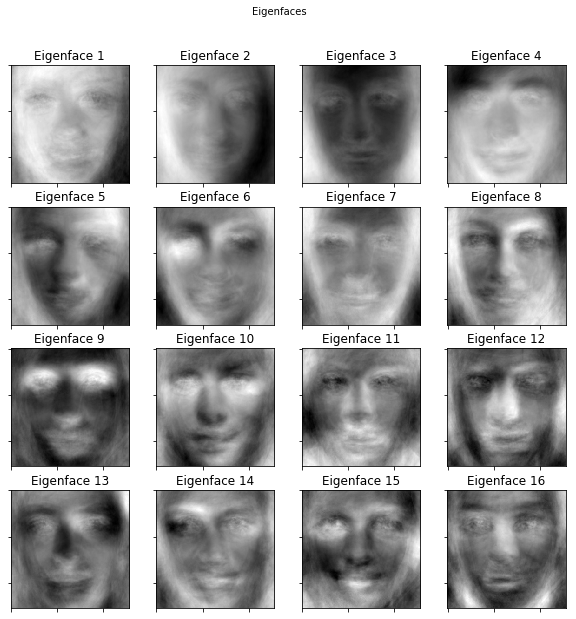

In [25]:
subplot(title= "Eigenfaces", images = Eig_face , rows = 4 , cols = 4 , subt ="Eigenface", subts = numb)

In [16]:
image1 = 10
image2 = 40
image3 = 100
image4 = 2
image5 = 120
image6 = 200
image7 = 190
iamge8 = 340

In [17]:
E1, steps1 = reconstruct_img(image1)

In [28]:
E2, steps2 = reconstruct_img(image2)
E3, steps3 = reconstruct_img(image3)

In [29]:
E4, steps4 = reconstruct_img(image4)
E5, steps5 = reconstruct_img(image5)
E6, steps6 = reconstruct_img(image6)
E7, steps7 = reconstruct_img(image7)

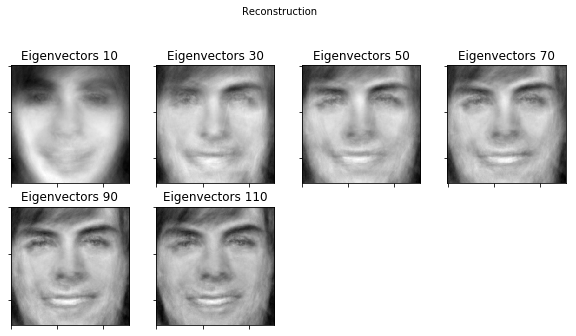

In [30]:
subplot(title= "Reconstruction", images = E3 , rows = 4 , cols = 4 , subt ="Eigenvectors", subts = steps3)

In [31]:
##plot MSE vs Eigenvalues
Error = []
for i in range(len(steps1)):
    Error.append((MSE(E1[i], X[image1]) + MSE(E2[i], X[image2]) + MSE(E3[i], X[image3]) +  MSE(E4[i], X[image4]) +  MSE(E5[i], X[image5]) +  MSE(E6[i], X[image6] +  MSE(E7[i], X[image7])))/7)

Text(0,0.5,'MSE')

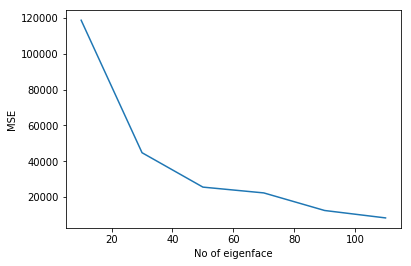

In [32]:
plt.plot(steps1, Error)
plt.xlabel('No of eigenface')
plt.ylabel('MSE')

In [36]:
s = []
for i in range(0, 9):
    s.append(np.reshape(p[i,:], (256, 256)))

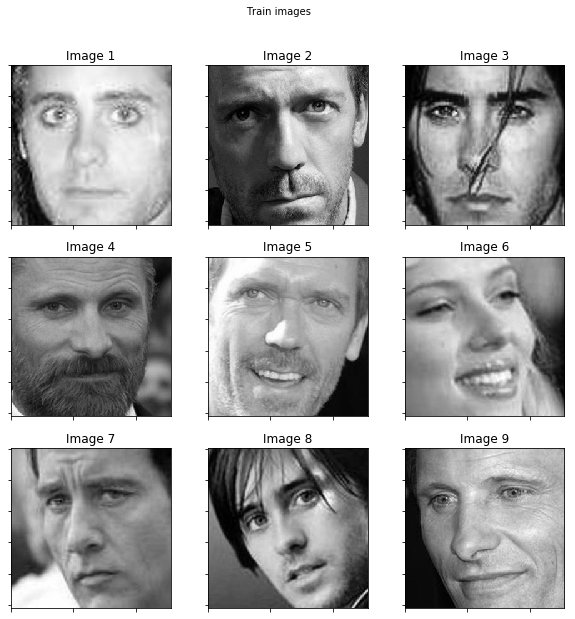

In [37]:
subplot(title= "Train images", images = s , rows = 3 , cols = 3 , subt ="Image", subts = steps)

Text(0.5,1,'Mean Face Image')

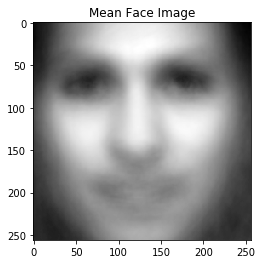

In [42]:
plt.imshow(np.reshape(mu, (256, 256)), cmap = 'gray')
plt.title('Mean Face Image')

In [33]:
def weight_img(image, components):
    numEvs = components
    P = project(eig_vecs[:,0:numEvs], image.reshape(1,-1), mu)
    return P

In [34]:
X1 = []
X2 = []
X3 = []
for i in range(0, len(X)):
    X1.append(weight_img(X[i], 1).flatten())
    X2.append(weight_img(X[i], 2).flatten())
    X3.append(weight_img(X[i], 3).flatten())

Text(0.5,0,'Images')

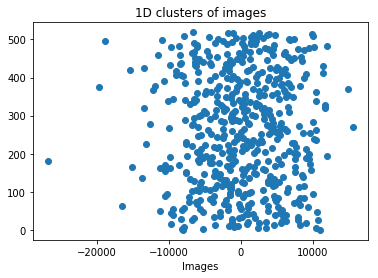

In [76]:
Y = [i for i in range(0, 520)]
plt.scatter(X1, Y)
plt.title("1D clusters of images")
plt.xlabel("Images")

Text(0,0.5,'2nd feature of Image')

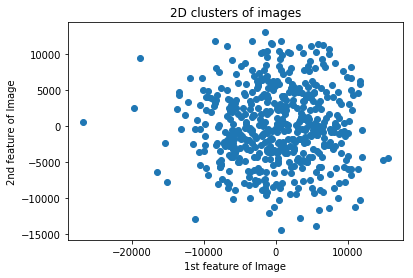

In [81]:
Y = [i for i in range(0, 520)]
plt.scatter(X2[:,0], X2[:,1])
plt.title("2D clusters of images")
plt.xlabel("1st feature of Image")
plt.ylabel("2nd feature of Image")

Text(0.5,0,'3rd feature')

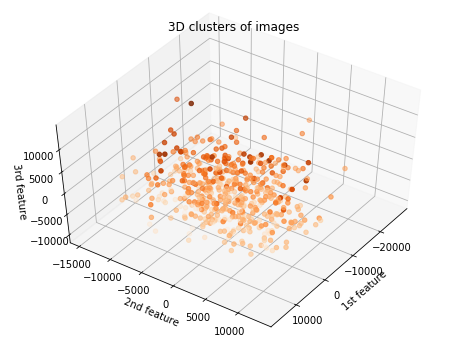

In [80]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], c=X3[:,2], cmap='Oranges')
ax.view_init(50, 35)
ax.set_title("3D clusters of images")
ax.set_xlabel('1st feature')
ax.set_ylabel('2nd feature')
ax.set_zlabel('3rd feature')